In [1]:
import os
import tqdm
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
%run ./MyNetwork.ipynb

In [3]:
_DATA_PATH = './UTKFace/'

2 ways to preprocess pictures
1. 200x200x3 (3 channels) --PCA--> 128
2. 200x200 (gray scale) --PCA--> 128

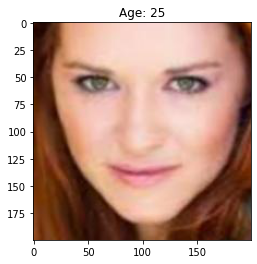

In [4]:
plt.imshow(np.array(Image.open(_DATA_PATH + os.listdir(_DATA_PATH)[6])))
plt.title('Age: ' + str(25))
plt.show()

Utility functions:

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.3333, 0.3333, 0.3333])

def data_loader(DATA_PATH = _DATA_PATH, flatten = True):
    now = time.time()
    img_data = []
    age = []
    sex = []
    nationality = []
    for image_path in os.listdir(DATA_PATH):
        try:
            image = np.array(Image.open(DATA_PATH + image_path))
            image = rgb2gray(image.astype('float32'))
            image = image / 255
            if flatten: image = image.flatten()
            a = int(image_path.split('_')[0])
            s = int(image_path.split('_')[1])
            n = int(image_path.split('_')[2])
            img_data.append(image)
            age.append(a)
            sex.append(s)
            nationality.append(n)
        except:
            continue
    print('Dataset loaded in', time.time() - now, 'seconds.')
    return np.array(img_data), np.array(age), np.array(sex), np.array(nationality)

def PCA_(data, _n_components = 128):
    pca = PCA(n_components = _n_components, svd_solver = 'randomized')
    pca = pca.fit(data)
    data_reduced = pca.transform(data)
    return data_reduced

In [6]:
img_data, age, sex, nationality = data_loader()

Dataset loaded in 36.38893008232117 seconds.


Sample image:


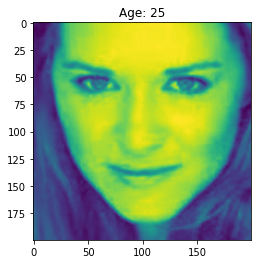

In [7]:
print('Sample image:')
plt.title('Age: ' + str(age[6]))
plt.imshow(img_data[6].reshape((200, 200)))
plt.show()
# print(img_data[0].reshape((200, 200)))

In [8]:
reduced_img_data = PCA_(img_data, _n_components = 128)
reduced_img_data.shape

(23705, 128)

## MLP for age prediction

In [9]:
_age = age.reshape(-1, 1)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_img_data, _age, test_size=0.1, random_state=42)

In [11]:
%run ./MyNetwork.ipynb

In [12]:
BATCH_SIZE = 128
CLASSES = 1
INPUT_SHAPE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.1
EPOCHS = 150

In [13]:
trainloader = Dataloader(X_train, Y_train, BATCH_SIZE)
testloader = Dataloader(X_test, Y_test)

In [14]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(35, activation = LeakyRelu())
network.add_layer(6, activation = LeakyRelu())
network.add_layer(1, activation = LeakyRelu())
network.set_training_param(momentum = MOMENTUM, loss = MSE(), lr = 'AUTO')

3 layers:
35 neurons. activation function: LeakyReLu
6 neurons. activation function: LeakyReLu
1 neurons. activation function: LeakyReLu
Momentum:	0.1
Loss Function:	 L2


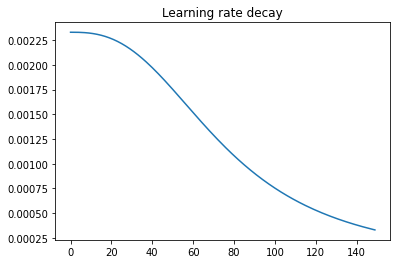

In [15]:
network.get_network_info()

In [16]:
result = network.fit(EPOCHS, trainloader, testloader, log = 0)

In [17]:
train_losses, test_losses = result['train_loss'], result['test_loss']

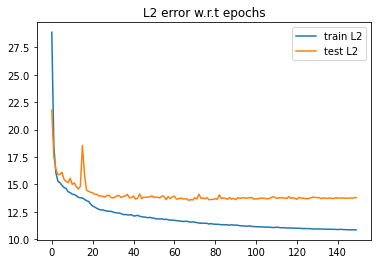

In [18]:
plt.plot(range(150), np.array(train_losses) ** (1/2), label = 'train L2')
plt.plot(range(150), np.array(test_losses) ** (1/2), label = 'test L2')
plt.title('L2 error w.r.t epochs')
plt.legend()

In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(reduced_img_data, age.reshape(1, -1)[0])
res = clf.predict(reduced_img_data)
np.mean((res - age.reshape(1, -1)[0])**2) ** (1/2)

/Users/ali/Desktop/test/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15.748449701558917

## MLP for nationality prediction

In [301]:
%run ./MyNetwork.ipynb

In [302]:
_nationality = nationality.reshape(-1, 1)
onehot_nationality = OneHotEncoder().fit_transform(_nationality).toarray()

In [303]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_img_data, onehot_nationality, test_size= 0.12, random_state=42)

In [304]:
BATCH_SIZE = 100
CLASSES = onehot_nationality.shape[1]
INPUT_SHAPE = 128
LEARNING_RATE = 'AUTO'
MOMENTUM = 0.1
EPOCHS = 300

In [305]:
trainloader = Dataloader(X_train, Y_train, BATCH_SIZE)
testloader = Dataloader(X_test, Y_test)

In [306]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(50, activation = LeakyRelu(), w_limit = 'LOW')
network.add_layer(3, activation = LeakyRelu(), w_limit = 'LOW')
network.add_layer(CLASSES, activation = Softmax(), w_limit = 'LOW')
network.set_training_param(momentum = MOMENTUM, loss = CrossEntropySoftmax(), lr = LEARNING_RATE)

3 layers:
50 neurons. activation function: LeakyReLu
3 neurons. activation function: LeakyReLu
5 neurons. activation function: Softmax
Momentum:	0.1
Loss Function:	 CrossEntropySoftmax


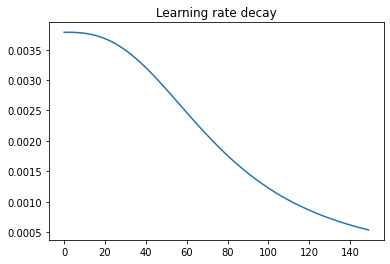

In [307]:
network.get_network_info()

In [308]:
result = network.fit(EPOCHS, trainloader, testloader, log = 0, acc = True)

-------------------------------
--- Tooks 72.839(s) to fit. ---
-------------------------------


In [309]:
train_losses, test_losses = result['train_loss'], result['test_loss']
train_accs, test_accs = result['train_acc'], result['test_acc']

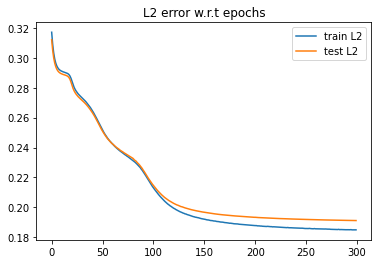

In [310]:
plt.plot(range(len(train_losses)), np.array(train_losses), label = 'train L2')
plt.plot(range(len(test_losses)), np.array(test_losses), label = 'test L2')
plt.title('L2 error w.r.t epochs')
plt.legend()

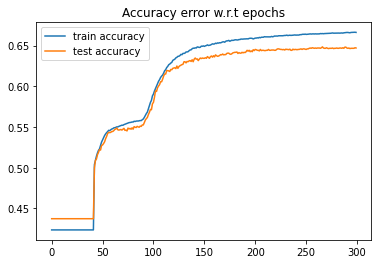

In [311]:
plt.plot(range(len(train_accs)), np.array(train_accs), label = 'train accuracy')
plt.plot(range(len(test_accs)), np.array(test_accs), label = 'test accuracy')
plt.title('Accuracy error w.r.t epochs')
plt.legend()

## MLP for sexuality prediction

In [296]:
%run ./MyNetwork.ipynb

In [297]:
_sex = sex.reshape(-1, 1)
onehot_sex = OneHotEncoder().fit_transform(_sex).toarray()

In [298]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_img_data, onehot_sex, test_size= 0.12, random_state=42)

In [299]:
BATCH_SIZE = 128
CLASSES = onehot_sex.shape[1]
INPUT_SHAPE = 128
LEARNING_RATE = 0.0025
MOMENTUM = 0.1
EPOCHS = 180

In [300]:
trainloader = Dataloader(X_train, Y_train, BATCH_SIZE)
testloader = Dataloader(X_test, Y_test)

In [203]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(44, activation = LeakyRelu(), w_limit = 'LOW')
network.add_layer(8, activation = LeakyRelu(), w_limit = 'LOW')
network.add_layer(2, activation = Softmax(), w_limit = 'LOW')
network.set_training_param(momentum = MOMENTUM, loss = CrossEntropySoftmax(), lr = 'AUTO')

3 layers:
44 neurons. activation function: LeakyReLu
8 neurons. activation function: LeakyReLu
2 neurons. activation function: Softmax
Momentum:	0.1
Loss Function:	 CrossEntropySoftmax


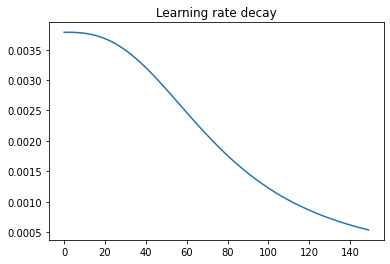

In [204]:
network.get_network_info()

In [205]:
result = network.fit(EPOCHS, trainloader, testloader, log = 1, acc = True)

--------------- EPOCH: #0 ---------------
learning rate:	0.00379
trin Loss:	0.3464	test Loss:	0.3464
trin accuracy:	0.5231	test accuracy:	0.5202

--------------- EPOCH: #1 ---------------
learning rate:	0.00379
trin Loss:	0.3463	test Loss:	0.3463
trin accuracy:	0.5231	test accuracy:	0.5202

--------------- EPOCH: #2 ---------------
learning rate:	0.00379
trin Loss:	0.3461	test Loss:	0.3462
trin accuracy:	0.5231	test accuracy:	0.5202

--------------- EPOCH: #3 ---------------
learning rate:	0.00379
trin Loss:	0.3461	test Loss:	0.3462
trin accuracy:	0.5231	test accuracy:	0.5202

--------------- EPOCH: #4 ---------------
learning rate:	0.00378
trin Loss:	0.3461	test Loss:	0.3461
trin accuracy:	0.5231	test accuracy:	0.5202

--------------- EPOCH: #5 ---------------
learning rate:	0.00378
trin Loss:	0.346	test Loss:	0.3461
trin accuracy:	0.5231	test accuracy:	0.5202

--------------- EPOCH: #6 ---------------
learning rate:	0.00378
trin Loss:	0.346	test Loss:	0.3461
trin accuracy:	0.5231	tes

--------------- EPOCH: #56 ---------------
learning rate:	0.00262
trin Loss:	0.1925	test Loss:	0.1968
trin accuracy:	0.8446	test accuracy:	0.8408

--------------- EPOCH: #57 ---------------
learning rate:	0.00258
trin Loss:	0.1907	test Loss:	0.1965
trin accuracy:	0.8446	test accuracy:	0.8383

--------------- EPOCH: #58 ---------------
learning rate:	0.00254
trin Loss:	0.1893	test Loss:	0.1942
trin accuracy:	0.8457	test accuracy:	0.8425

--------------- EPOCH: #59 ---------------
learning rate:	0.0025
trin Loss:	0.1877	test Loss:	0.1931
trin accuracy:	0.8475	test accuracy:	0.8446

--------------- EPOCH: #60 ---------------
learning rate:	0.00247
trin Loss:	0.1863	test Loss:	0.1923
trin accuracy:	0.8486	test accuracy:	0.845

--------------- EPOCH: #61 ---------------
learning rate:	0.00243
trin Loss:	0.185	test Loss:	0.1906
trin accuracy:	0.8496	test accuracy:	0.8482

--------------- EPOCH: #62 ---------------
learning rate:	0.00239
trin Loss:	0.1838	test Loss:	0.19
trin accuracy:	0.8501

--------------- EPOCH: #112 ---------------
learning rate:	0.00099
trin Loss:	0.1624	test Loss:	0.1742
trin accuracy:	0.8675	test accuracy:	0.8524

--------------- EPOCH: #113 ---------------
learning rate:	0.00097
trin Loss:	0.1622	test Loss:	0.1741
trin accuracy:	0.8666	test accuracy:	0.8527

--------------- EPOCH: #114 ---------------
learning rate:	0.00095
trin Loss:	0.162	test Loss:	0.174
trin accuracy:	0.8673	test accuracy:	0.851

--------------- EPOCH: #115 ---------------
learning rate:	0.00094
trin Loss:	0.1619	test Loss:	0.1745
trin accuracy:	0.8653	test accuracy:	0.8524

--------------- EPOCH: #116 ---------------
learning rate:	0.00092
trin Loss:	0.1618	test Loss:	0.1738
trin accuracy:	0.8673	test accuracy:	0.852

--------------- EPOCH: #117 ---------------
learning rate:	0.00091
trin Loss:	0.1616	test Loss:	0.174
trin accuracy:	0.8676	test accuracy:	0.852

--------------- EPOCH: #118 ---------------
learning rate:	0.00089
trin Loss:	0.1615	test Loss:	0.1738
trin accuracy:	

--------------- EPOCH: #168 ---------------
learning rate:	0.00041
trin Loss:	0.1573	test Loss:	0.1715
trin accuracy:	0.8708	test accuracy:	0.8524

--------------- EPOCH: #169 ---------------
learning rate:	0.0004
trin Loss:	0.1572	test Loss:	0.1718
trin accuracy:	0.8699	test accuracy:	0.8545

--------------- EPOCH: #170 ---------------
learning rate:	0.00039
trin Loss:	0.1571	test Loss:	0.1715
trin accuracy:	0.871	test accuracy:	0.8541

--------------- EPOCH: #171 ---------------
learning rate:	0.00039
trin Loss:	0.1571	test Loss:	0.1715
trin accuracy:	0.871	test accuracy:	0.8545

--------------- EPOCH: #172 ---------------
learning rate:	0.00038
trin Loss:	0.1571	test Loss:	0.1714
trin accuracy:	0.8707	test accuracy:	0.8527

--------------- EPOCH: #173 ---------------
learning rate:	0.00038
trin Loss:	0.157	test Loss:	0.1715
trin accuracy:	0.8713	test accuracy:	0.8541

--------------- EPOCH: #174 ---------------
learning rate:	0.00037
trin Loss:	0.1569	test Loss:	0.1715
trin accuracy

In [206]:
train_losses, test_losses = result['train_loss'], result['test_loss']
train_accs, test_accs = result['train_acc'], result['test_acc']

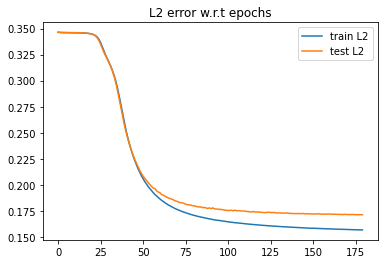

In [207]:
plt.plot(range(180), np.array(train_losses), label = 'train L2')
plt.plot(range(180), np.array(test_losses), label = 'test L2')
plt.title('L2 error w.r.t epochs')
plt.legend()

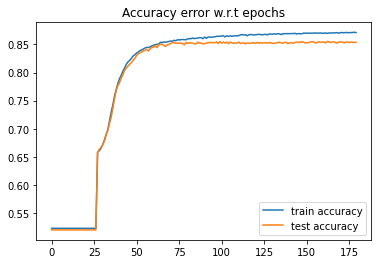

In [208]:
plt.plot(range(180), np.array(train_accs), label = 'train accuracy')
plt.plot(range(180), np.array(test_accs), label = 'test accuracy')
plt.title('Accuracy error w.r.t epochs')
plt.legend()